## Assignment 3 -- SALVADOR GARCIA -- s1655274

## Problem 1

In [205]:
function GenerateData(n::Int64, d::Int64, theta,a_pos,a_neg,sigma) 
    X = zeros(d, n)
    y = zeros(n, 1)
    for i = 1:n
        t = rand()
        if t < theta
            X[:,i] = (randn(d, 1)*sigma + ones(d,1)*a_pos)
            y[i] = 1
        else
            X[:,i] = (randn(d, 1)*sigma + ones(d,1)*a_neg)
            y[i] = -1
        end
    end
    return (X, y)
end 

GenerateData (generic function with 1 method)

## Problem 2

In [227]:
function SmoothedHingeLoss(X,y)
    function SHL(i,w)
        z = y[i]*(X[:,i]'*w)[1]        # Calculate just 1 time
        if z > 1
            return 0
        elseif z < 0
            return (.5 - z)
        else
            return (.5*(1-z)*(1-z))
        end
    end
    
    function SHLgrad(i,w)
        z = y[i]*(X[:,i]'*w)[1]
        if z > 1
            return 0
        elseif z < 0
            return (-y[i])
        else
            return (-y[i]+(y[i]*z))
        end
    end
    
    P(w) = (1/n)*sum([SHL(i,w) for i=1:n]) + (lambda/2*w'*w)[1]
    return (SHLgrad, P)
end

SmoothedHingeLoss (generic function with 1 method)

In [230]:
srand(123456)
d = 2
n = 10^3
lambda = 1/n
theta = 0.5
N = 1000

X, y = GenerateData(n, d, theta, 10, -10, 1);
SHLgrad, P = SmoothedHingeLoss(X, y)
println(SHLgrad(3, [.01,.01]))
println(P([.01,.01]))

-0.8146621668362124
0.3198231550036817


## Problem 3

In [207]:
function SGD(h, N, w0)
    fx_val = zeros(N,1)
    w = zeros(d, 1)
    w = w0
    print(P(w))
    for i =1:N
        selected_ind = rand(1:n, 1)[1]
        w = w - h*(SHLgrad(selected_ind, w)*X[:,selected_ind]+ lambda*w)
        fx_val[i] = P(w)
    end
    return (fx_val, w)
end

SGD (generic function with 1 method)

In [208]:
srand(123456)
d = 2
n = 10^3
lambda = 1/n
theta = 0.5
N = 1000

X, y = GenerateData(n, d, theta, 10, -10, 1);
SHLgrad, P = SmoothedHingeLoss(X, y)
fx_r_1, w_sgd1 = SGD(.1, N, [100,100]);
fx_r_4, w_sgd2 = SGD(.4, N, [100,100]);
fx_r1, w_sgd3 = SGD(1, N, [100,100]);
fx_r4, w_sgd4 = SGD(4, N, [100,100]);


10.0

LoadError: InterruptException:

In [209]:
w_fin

2-element Array{Float64,1}:
 0.0594365
 0.0609136

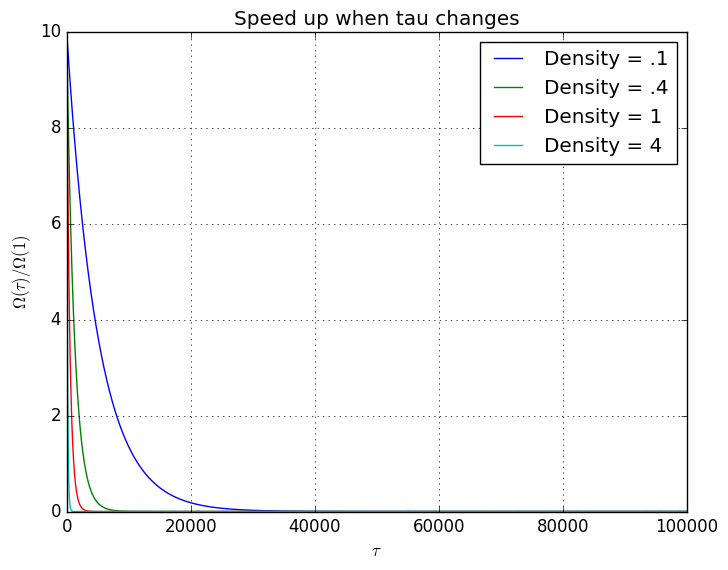

In [210]:
using PyPlot
plt[:plot](1:N, fx_r_1, "-", linewidth=1.0, label="Density = .1")
plt[:plot](1:N, fx_r_4, "-", linewidth=1.0, label="Density = .4")
plt[:plot](1:N, fx_r1, "-", linewidth=1.0, label="Density = 1")
plt[:plot](1:N, fx_r4, "-", linewidth=1.0, label="Density = 4")
legend(loc="upper right")
xlabel(L"\tau")
ylabel(L"\Omega(\tau)/\Omega(1)")
title("Speed up when tau changes")
grid("on")


## Problem 4

In [260]:
function dfSDCA(N,alpha0)   
    w = (1/(lambda*n))*X*alpha0
    alpha = alpha0
    w_p = zeros(N,1)
    
    theta = lambda/(norm(X[:,1])^2+n*lambda)    
    
    for i = 2:n
        temp = lambda/(norm(X[:,i])^2+n*lambda)    
        if temp < theta
            theta = temp
        end
    end

    for k = 1:N
        selected_ind = rand(1:n, 1)[1]
        alpha[selected_ind] -= n*theta*(SHLgrad(selected_ind, w)+alpha[selected_ind])        
        w -= (theta/lambda)*(SHLgrad(selected_ind, w) + alpha[selected_ind])*X[:,selected_ind]
        w_p[k] = P(w)
    end
    return (w_p, w) 
end

srand(123456)
α_0 = zeros(n)
N = 100
w_p, w_orig = dfSDCA(N, α_0);
w_p

100×1 Array{Float64,2}:
 0.0448101  
 0.00982728 
 0.00186997 
 0.00131025 
 0.00131025 
 0.000289219
 0.000194227
 0.000194227
 0.000194227
 0.000194227
 0.000152152
 0.000152152
 0.000152152
 ⋮          
 2.06474e-5 
 2.06474e-5 
 2.06474e-5 
 2.06474e-5 
 2.06474e-5 
 2.06474e-5 
 2.06474e-5 
 2.06474e-5 
 2.06474e-5 
 2.06474e-5 
 2.06474e-5 
 2.06474e-5 

In [261]:
srand(123456)
alpha0 = zeros(n,1)
N = 100000
w_p, w_orig = dfSDCA(N, alpha0);

using PyPlot
plt[:plot](1:N, w_p, "-", linewidth=1.0, label="")
legend(loc="upper right")
xlabel(L"Iterations")
ylabel(L"P(w)")
title("Decreasing with dfSDCA")
grid("on")


LoadError: InterruptException:

## Problem 5

In [201]:
function samplingK(k, n) 
    reservoir = collect(1:k)
    for i=(k+1):n
        pos = rand(1:i)
        if pos <= k
            reservoir[pos] = i
        end
    end
    return reservoir
end

samplingK (generic function with 1 method)

In [202]:
function mdfSDCA(N, tau, alpha0)
    p=ones(n)*tau/n
    v = [norm(X[:,i])^2 for i=1:n]
    theta = minimum(p*lambda*n./(v + lambda*n))
    w = (1/(lambda*n))*X*alpha0
    alpha = alpha0
    w_p = zeros(N,1)
    
    for k = 1:N
        for i in samplingK(tau,n)      
            delta = SHLgrad(i,w) + alpha[i] 
            alpha[i] -= theta/p[i]*(delta)
            w -= (X[:,i]*theta*delta) / (lambda*n*p[i])
        end
        w_p[k] = P(w)
    end
    return (w_p, w) 
end

mdfSDCA (generic function with 1 method)

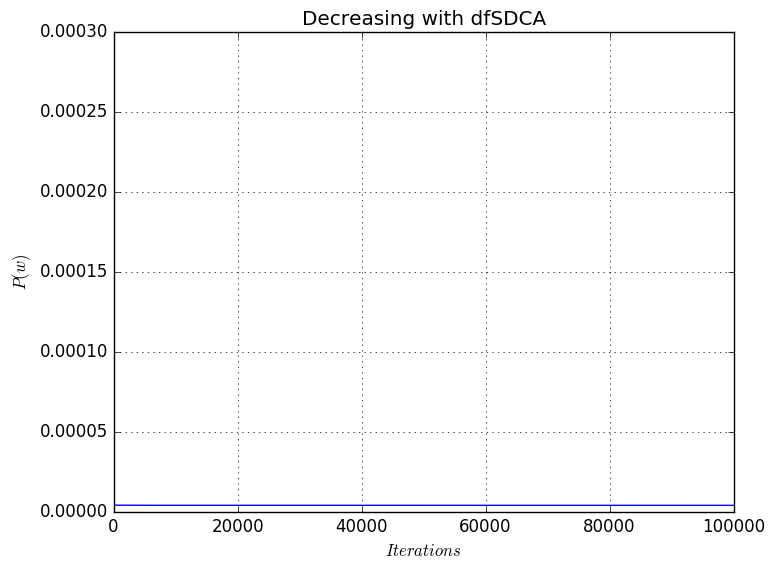

In [203]:
srand(123456)
alpha0 = zeros(n,1)
N = 100000
tau = 10
w_p, w_mult = mdfSDCA(N, tau, alpha0);

using PyPlot
plt[:plot](1:N, w_p, "-", linewidth=1.0, label="")
legend(loc="upper right")
xlabel(L"Iterations")
ylabel(L"P(w)")
title("Decreasing with dfSDCA")
grid("on")

In [204]:
println(w_sgd1)
println(w_sgd2)
println(w_sgd3)
println(w_sgd4)
println(w_orig)
println(w_mult)

[0.0740803,0.072869]
[0.0869896,0.0733434]
[0.0729986,0.0899387]
[0.208945,0.199096]
[0.0633443; 0.0606573]
[0.0630977; 0.0606762]
